## Multilabel Classification of Reviews 

Dataset Source: https://www.kaggle.com/datasets/mohamedziauddin/mh-uhack-sentiments

##### Import Necessary Libraries

In [17]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

import transformers
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

!git lfs install

Git LFS initialized.


##### Display Version of Relevant Libraries

In [18]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Torch:".rjust(15), transformers.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
        Pandas: 1.5.0
         NumPy: 1.23.3
         Torch: 4.26.1
  Transformers: 4.26.1
      Datasets: 2.8.0
      Evaluate: 0.2.2


##### Ingest Data & Drop Unnecessary Feature

In [19]:
parent_dir = "/Users/briandunn/Desktop/uHack Sentiments"

df = pd.read_csv(os.path.join(parent_dir, "train.csv"))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6136 entries, 0 to 6135
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Id                             6136 non-null   int64 
 1   Review                         6136 non-null   object
 2   Components                     6136 non-null   int64 
 3   Delivery and Customer Support  6136 non-null   int64 
 4   Design and Aesthetics          6136 non-null   int64 
 5   Dimensions                     6136 non-null   int64 
 6   Features                       6136 non-null   int64 
 7   Functionality                  6136 non-null   int64 
 8   Installation                   6136 non-null   int64 
 9   Material                       6136 non-null   int64 
 10  Price                          6136 non-null   int64 
 11  Quality                        6136 non-null   int64 
 12  Usability                      6136 non-null   int64 
 13  Pol

##### Data Preprocessing

In [20]:
df.drop(columns=["Id"], inplace=True)

df.head()

,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1
2,Excellent ceiling fan brace. Easy to install a...,0,0,0,0,0,0,1,0,0,1,0,1
3,Work great easy to use . No issues at all with...,0,0,0,0,0,1,0,0,0,0,1,1
4,I would recommend this product because it is p...,0,0,0,0,0,0,0,0,0,1,0,1


##### Visual: Histogram of Article Abstract's Word Lengths

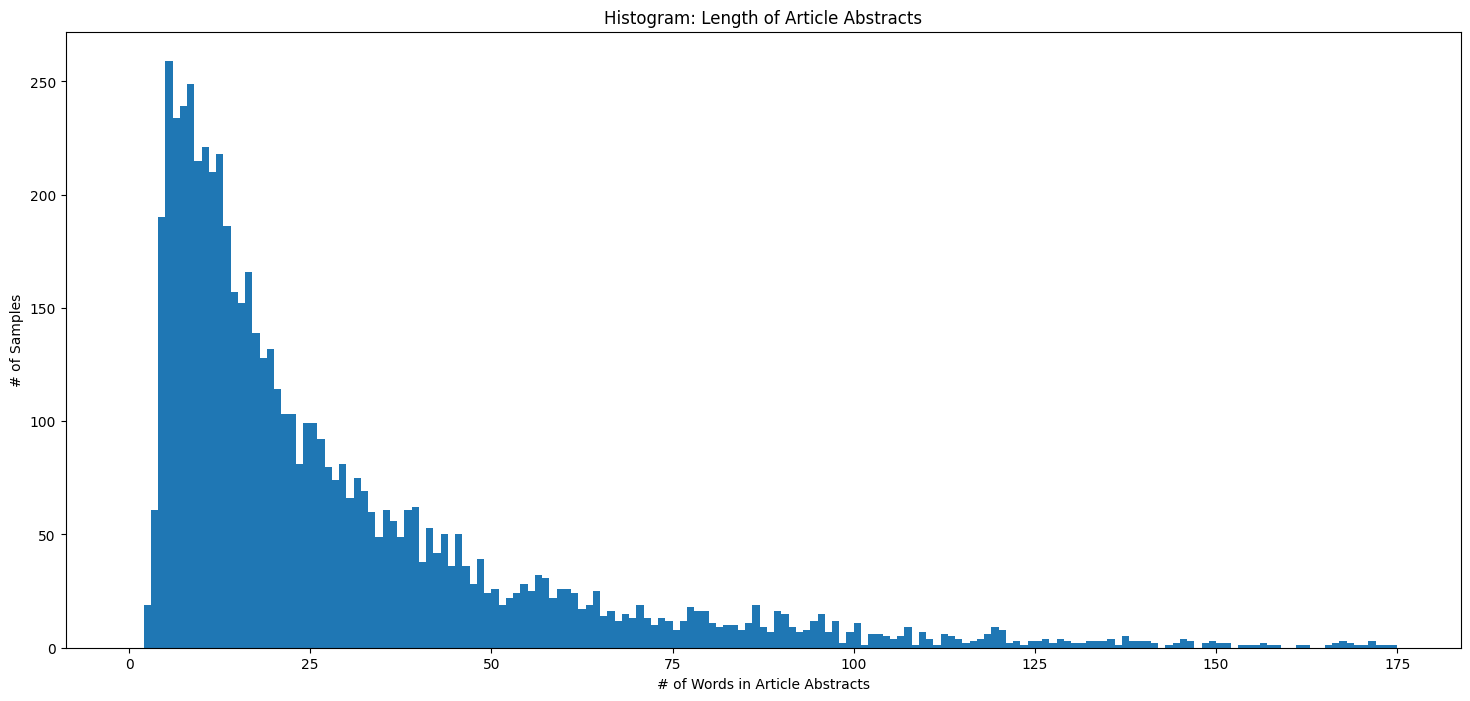

The maximum length of Article Abstracts (in words) is 374 words.


In [21]:
df['text_length'] = df['Review'].str.split().str.len()

n_bin=175
df.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(df['text_length'])} words.")

##### Data Preprocessing

In [22]:
upper_limit=176

df = df[df['text_length'] < upper_limit]

df.drop(columns=["text_length"], inplace=True)

df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Review                         6092 non-null   object
 1   Components                     6092 non-null   int64 
 2   Delivery and Customer Support  6092 non-null   int64 
 3   Design and Aesthetics          6092 non-null   int64 
 4   Dimensions                     6092 non-null   int64 
 5   Features                       6092 non-null   int64 
 6   Functionality                  6092 non-null   int64 
 7   Installation                   6092 non-null   int64 
 8   Material                       6092 non-null   int64 
 9   Price                          6092 non-null   int64 
 10  Quality                        6092 non-null   int64 
 11  Usability                      6092 non-null   int64 
 12  Polarity                       6092 non-null   int64 
dtypes: 

##### Create List of Labels & Dictionaries for Converting Between Strings & Integers

In [23]:
labels = [x for x in df.columns if x not in ['Review', "Id"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
NUM_OF_LABELS = len(labels)

##### Convert Pandas DataFrame to Datasets & Split Dataset into Training/Testing/Evaluation Datasets

In [24]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (4873, 13)
Testing Dataset Shape: (609, 13)
Evaluation Dataset Shape: (610, 13)


{'Review': 'They are sturdily made with great clamping power.',
 'Components': 0,
 'Delivery and Customer Support': 0,
 'Design and Aesthetics': 0,
 'Dimensions': 0,
 'Features': 0,
 'Functionality': 0,
 'Installation': 0,
 'Material': 0,
 'Price': 0,
 'Quality': 1,
 'Usability': 0,
 'Polarity': 1}

#### Basic Values/Constants

In [25]:
set_seed = 42
NUM_OF_EPOCHS = 10

BATCH_SIZE = 16
LEARNING_RATE = 2e-5

MAX_LENGTH = int(round((upper_limit - 1) * 1.3, 0))
MODEL_CKPT = "distilbert-base-uncased"
MODEL_NAME = MODEL_CKPT + "-reviews_multilabel_clf_v2"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")
print(f"This project will utilize the {DEVICE} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")

This project will utilize the cpu to train and evaluate.
This project will have a maximum length for the input text of 228 tokens.


##### Create Tokenizer

In [26]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	# take a batch of text
	text = examples["Review"]
	# encode them
	encoded_data = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
	# add labels
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	# create numpy array of shape (batch_size, num_labels)
	labels_matrix = np.zeros((len(text), len(labels)))
	# fill numpy array	
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()
  
	return encoded_data

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/briandunn/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /Users/briandunn/.cache/huggingface/hub/model

##### Tokenize Dataset

In [27]:
encoded_ds = ds.map(data_preprocessor, batched=True, load_from_cache_file=False)
encoded_ds.set_format("torch")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

##### Print Dataset Shapes to Make Sure Prepared for Later

In [28]:
print(f"The shape of the training dataset is: {encoded_ds['train'].shape}")
print(f"The shape of the testing dataset is: {encoded_ds['test'].shape}")
print(f"The shape of the evaluation dataset is: {encoded_ds['eval'].shape}")

The shape of the training dataset is: (4873, 16)
The shape of the testing dataset is: (609, 16)
The shape of the evaluation dataset is: (610, 16)


##### Define Model

In [29]:
model = (DistilBertForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                             num_labels=NUM_OF_LABELS, 
                                                             problem_type="multi_label_classification",
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Components",
    "1": "Delivery and Customer Support",
    "2": "Design and Aesthetics",
    "3": "Dimensions",
    "4": "Features",
    "5": "Functionality",
    "6": "Installation",
    "7": "Material",
    "8": "Price",
    "9": "Quality",
    "10": "Usability",
    "11": "Polarity"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Components": 0,
    "Delivery and Customer Support": 1,
    "Design and Aesthetics": 2,
    "Dimensions": 3,
    "Features": 4,
    "Functionality": 5,
    "Installation": 6,
    "Material": 7,
    "Polarity": 11,
    "Price": 8,
    "Quality": 9,
    

##### Create Metrics Evaluation Function

In [30]:
def multi_label_metrics(predictions, 
                        labels, 
                        threshold=0.5):
    '''
    This function calculates & returns metrics 
    for a multilabel classification analysis.
    '''
    
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return metrics as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    preds = preds[0] if isinstance(preds, 
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds, 
                    labels=labels)
    return results

##### Define Training Arguments

In [31]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


##### Instantiate Trainer

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-reviews_multilabel_clf_v2 into local empty directory.


##### Train Model

In [33]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4873
  Num Epochs

A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6847, 'learning_rate': 1.999344262295082e-05, 'epoch': 0.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-305
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-305/config.json


{'eval_loss': 0.24248847365379333, 'eval_f1': 0.7619047619047619, 'eval_roc_auc': 0.8209455005668784, 'eval_accuracy': 0.34918032786885245, 'eval_runtime': 321.9996, 'eval_samples_per_second': 1.894, 'eval_steps_per_second': 0.121, 'epoch': 1.0}


Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-305/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-305/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-305/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.296, 'learning_rate': 1.6721311475409837e-05, 'epoch': 1.64}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-610
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-610/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-610/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-610/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-610/special_tokens_map.json


{'eval_loss': 0.1786002665758133, 'eval_f1': 0.8447387785136129, 'eval_roc_auc': 0.8846977966444308, 'eval_accuracy': 0.519672131147541, 'eval_runtime': 316.8849, 'eval_samples_per_second': 1.925, 'eval_steps_per_second': 0.123, 'epoch': 2.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-915
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-915/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-915/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-915/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-915/special_tokens_map.json


{'eval_loss': 0.16335400938987732, 'eval_f1': 0.8510638297872339, 'eval_roc_auc': 0.8937335759045886, 'eval_accuracy': 0.5360655737704918, 'eval_runtime': 315.4442, 'eval_samples_per_second': 1.934, 'eval_steps_per_second': 0.124, 'epoch': 3.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


{'loss': 0.1476, 'learning_rate': 1.3442622950819673e-05, 'epoch': 3.28}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1220
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1220/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1220/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1220/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1220/special_tokens_map.json


{'eval_loss': 0.15440578758716583, 'eval_f1': 0.8626174981923355, 'eval_roc_auc': 0.8999059596945008, 'eval_accuracy': 0.5622950819672131, 'eval_runtime': 315.4537, 'eval_samples_per_second': 1.934, 'eval_steps_per_second': 0.124, 'epoch': 4.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


{'loss': 0.0986, 'learning_rate': 1.0163934426229509e-05, 'epoch': 4.92}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1525
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1525/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1525/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1525/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1525/special_tokens_map.json


{'eval_loss': 0.1489531248807907, 'eval_f1': 0.8624185372918175, 'eval_roc_auc': 0.8993891774549353, 'eval_accuracy': 0.5639344262295082, 'eval_runtime': 305.3281, 'eval_samples_per_second': 1.998, 'eval_steps_per_second': 0.128, 'epoch': 5.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1830
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1830/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1830/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1830/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-1830/special_tokens_map.json


{'eval_loss': 0.15214788913726807, 'eval_f1': 0.865329512893983, 'eval_roc_auc': 0.9041228324588464, 'eval_accuracy': 0.578688524590164, 'eval_runtime': 304.9839, 'eval_samples_per_second': 2.0, 'eval_steps_per_second': 0.128, 'epoch': 6.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


{'loss': 0.0686, 'learning_rate': 6.885245901639345e-06, 'epoch': 6.56}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2135
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2135/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2135/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2135/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2135/special_tokens_map.json


{'eval_loss': 0.1510588526725769, 'eval_f1': 0.867579908675799, 'eval_roc_auc': 0.9110141412010794, 'eval_accuracy': 0.5655737704918032, 'eval_runtime': 320.6279, 'eval_samples_per_second': 1.903, 'eval_steps_per_second': 0.122, 'epoch': 7.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2440
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2440/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2440/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2440/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2440/special_tokens_map.json


{'eval_loss': 0.15014362335205078, 'eval_f1': 0.8687367678193366, 'eval_roc_auc': 0.910406834181454, 'eval_accuracy': 0.5868852459016394, 'eval_runtime': 320.2101, 'eval_samples_per_second': 1.905, 'eval_steps_per_second': 0.122, 'epoch': 8.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


{'loss': 0.0525, 'learning_rate': 3.6065573770491806e-06, 'epoch': 8.2}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2745
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2745/config.json


{'eval_loss': 0.1518922597169876, 'eval_f1': 0.8684863523573201, 'eval_roc_auc': 0.9089417389546586, 'eval_accuracy': 0.5754098360655737, 'eval_runtime': 322.2907, 'eval_samples_per_second': 1.893, 'eval_steps_per_second': 0.121, 'epoch': 9.0}


Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2745/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2745/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-2745/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


{'loss': 0.0432, 'learning_rate': 3.278688524590164e-07, 'epoch': 9.84}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050/special_tokens_map.json


{'eval_loss': 0.1519307792186737, 'eval_f1': 0.8696573648887318, 'eval_roc_auc': 0.9106625886571572, 'eval_accuracy': 0.578688524590164, 'eval_runtime': 316.8807, 'eval_samples_per_second': 1.925, 'eval_steps_per_second': 0.123, 'epoch': 10.0}


tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-reviews_multilabel_clf_v2/checkpoint-3050 (score: 0.8696573648887318).


{'train_runtime': 80885.961, 'train_samples_per_second': 0.602, 'train_steps_per_second': 0.038, 'train_loss': 0.11661010783226763, 'epoch': 10.0}


TrainOutput(global_step=3050, training_loss=0.11661010783226763, metrics={'train_runtime': 80885.961, 'train_samples_per_second': 0.602, 'train_steps_per_second': 0.038, 'train_loss': 0.11661010783226763, 'epoch': 10.0})

##### Evaluate Model

In [34]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality. If Functionality, Dimensions, Delivery and Customer Support, Price, Polarity, Components, Installation, Material, Features, Review, Design and Aesthetics, Usability, Quality are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 610
  Batch size = 16


A Jupyter Widget

{'eval_loss': 0.1519307792186737,
 'eval_f1': 0.8696573648887318,
 'eval_roc_auc': 0.9106625886571572,
 'eval_accuracy': 0.578688524590164,
 'eval_runtime': 328.461,
 'eval_samples_per_second': 1.857,
 'eval_steps_per_second': 0.119,
 'epoch': 10.0}

##### Push Model to HuggingFace Hub (My Profile!)

In [35]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-reviews_multilabel_clf_v2
Configuration saved in distilbert-base-uncased-reviews_multilabel_clf_v2/config.json
Model weights saved in distilbert-base-uncased-reviews_multilabel_clf_v2/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-reviews_multilabel_clf_v2/special_tokens_map.json


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-reviews_multilabel_clf_v2
   567ea22..d66b9a2  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'F1', 'type': 'f1', 'value': 0.8696573648887318}, {'name': 'Accuracy', 'type': 'accuracy', 'value': 0.578688524590164}]}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-reviews_multilabel_clf_v2
   d66b9a2..c9283b4  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-reviews_multilabel_clf_v2/commit/d66b9a283e407ab10e91740e837ba5631ebd2ff2'

### Notes & Other Takeaways From This Project
****
- This is the second training of this model. The changes that I made from the first project to this are:
    - Reduced the batch_size to 16 samples
    - Increase number of epochs to 10
****